In [31]:
import pandas as pd
import pickle
from pathlib import Path
import sys
import numpy as np
import pickle
import json
sys.path.append('../')
from lib.utils import load_data_features
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

data_dir = Path('/scratch/ssd001/home/haoran/projects/CovidForecast/data/')
root_dir = Path('/scratch/hdd001/home/haoran/CovidForecast/')

def highlight_min(s, n = 1):
    vals = sorted([i for i in s if isinstance(i, (float, np.float32, np.float64)) and not pd.isnull(i)])[:n]
    return ['font-weight: bold' if i in vals else '' for i in s]

## Results Table

In [45]:
eval_dir = Path('/scratch/hdd001/home/haoran/CovidProjections/covid19-forecast-hub-evaluation/evaluations/')
dates = ['2021-01-23', 
        '2021-02-06', 
        '2021-04-03',
        '2021-04-17']

dfs = []
actuals = []
for target in ['deaths', 'infections']:
    for date in dates:
        for i in (eval_dir/date).glob('all_errors*' + target +'.csv'):
            print(i)
            # df = pd.read_csv(i).rename(columns = {'Unnamed: 0': "Model"}).dropna(axis = 0)
            df = pd.read_csv(i).rename(columns = {'Unnamed: 0': "Model"})
            df['forecast_date'] = date
            all_states  =  [i for i in df.columns if i not in ('Model', 'US', 'forecast_date')]
            df['Mean_abs'] = df[all_states].abs().sum(axis = 1)/len(all_states)
            df['Mean_sq_root'] = np.sqrt((df[all_states]**2).sum(axis = 1)/len(all_states))
            df['target'] = target
            dfs.append(df)
            for j in (eval_dir/date).glob('state_actuals*' + str(date) + '_' + target + '.csv'):
                actuals.append(pd.read_csv(j).rename(columns = {'location': 'State', 'total_deaths': 'actual_deaths'}).assign(forecast_date = date,
                                                                                                                                target = target))
                break
            break

df = pd.concat(dfs)     
actuals = pd.concat(actuals).set_index('State')

/scratch/hdd001/home/haoran/CovidProjections/covid19-forecast-hub-evaluation/evaluations/2021-01-23/all_errors_2020-12-28_2021-01-23_deaths.csv
/scratch/hdd001/home/haoran/CovidProjections/covid19-forecast-hub-evaluation/evaluations/2021-02-06/all_errors_2020-12-28_2021-02-06_deaths.csv
/scratch/hdd001/home/haoran/CovidProjections/covid19-forecast-hub-evaluation/evaluations/2021-04-03/all_errors_2021-03-08_2021-04-03_deaths.csv
/scratch/hdd001/home/haoran/CovidProjections/covid19-forecast-hub-evaluation/evaluations/2021-04-17/all_errors_2021-03-08_2021-04-17_deaths.csv
/scratch/hdd001/home/haoran/CovidProjections/covid19-forecast-hub-evaluation/evaluations/2021-01-23/all_errors_2020-12-28_2021-01-23_infections.csv
/scratch/hdd001/home/haoran/CovidProjections/covid19-forecast-hub-evaluation/evaluations/2021-02-06/all_errors_2020-12-28_2021-02-06_infections.csv
/scratch/hdd001/home/haoran/CovidProjections/covid19-forecast-hub-evaluation/evaluations/2021-04-03/all_errors_2021-03-08_2021-0

In [46]:
# states_to_take = ['Mean_abs', 'Mean_sq_root']
states_to_take = ['US', 'California', 'New York', 'Texas', 'Mean_abs', 'Mean_sq_root', 'mean_abs_pct']
# states_to_take = ['Mean_abs', 'Mean_sq_root', 'mean_abs_pct']
# states_to_take = all_states
our_models = ['lode_stacked', 'lode', 'lode_states', 'lode_new', 'vgru_2021-03-08_4_US_cond_ts', 'gruode_2021-03-08_4_US_cond_ts',
             'vgru_2020-12-28_4_US_cond_ts', 'gruode_2020-12-28_4_US_cond_ts']

In [47]:
# models_to_take = ['UMass-MechBayes', 'CU-select', 'COVIDhub-ensemble', 'Caltech-CS156', 'GT-DeepCOVID', 'UCSD_NEU-DeepGLEAM',
#                  'Google_Harvard-CPF', 'USC-SI_kJalpha', 'UA-EpiCovDA', 'JHU_IDD-CovidSP', 'Columbia_UNC-SurvCon', 'UCLA-SuEIR',
#                      'TTU-squider', 'IowaStateLW-STEM'] + [our_model]

models_to_take = ['CU-select', 'COVIDhub-ensemble', 'Caltech-CS156', 'GT-DeepCOVID', 'UCSD_NEU-DeepGLEAM',
                 'Google_Harvard-CPF', 'USC-SI_kJalpha', 'UA-EpiCovDA', 'JHU_IDD-CovidSP', 'Columbia_UNC-SurvCon', 'UCLA-SuEIR',
                     'TTU-squider', 'IowaStateLW-STEM'] + our_models

In [48]:
def calc_mean_abs_pct(x):
    act = actuals[(actuals.forecast_date == x.forecast_date) & (actuals.target == x.target)].loc[all_states]['actual_deaths']
    errs = x[all_states]
    return pd.Series({'Model': x.Model, 'forecast_date': x.forecast_date, 'mean_abs_pct': np.abs((errs)/act).mean(),
                         'target': x.target})
abss = df.apply(calc_mean_abs_pct, axis = 1)
df = pd.merge(df, abss, on = ['Model', 'forecast_date', 'target'])

In [49]:
df_temp = df.copy()
df_temp[states_to_take] = df_temp[states_to_take].abs()
df_temp = df_temp[['Model', 'forecast_date', 'target'] + states_to_take].query('Model in @models_to_take')
df_temp = df_temp.pivot_table(index = ['Model'], columns = ['forecast_date', 'target'], values = states_to_take, aggfunc = lambda x: x)
df_temp.columns = pd.MultiIndex.from_tuples([(c, '%s/%s'% (a, b)) for a, b, c in df_temp.columns])
df_temp.T.sort_index().T.fillna('-').style.apply(lambda x: highlight_min(x, n = 2))

## Unseen Countries

In [144]:
# models = {
#     'lode': '/scratch/hdd001/home/haoran/CovidForecast/2021_model/2021-03-08-lode_2021-03-08_4_US_randomize-impute_from_cutoff.pkl',
#     'gruode': '/scratch/hdd001/home/haoran/CovidForecast/gruode_2021-03-08_4_US_randomize_cond_ts/2021-03-08-gruode_2021-03-08_4_US_randomize_cond_ts-impute_from_cutoff.pkl',
#     'vgru': '/scratch/hdd001/home/haoran/CovidForecast/vgru_2021-03-08_4_US_randomize_cond_ts/2021-03-08-vgru_2021-03-08_4_US_randomize_cond_ts-impute_from_cutoff.pkl',
# }

models = {
    'lode': '/scratch/hdd001/home/haoran/CovidForecast/2020_model/2020-12-28-lode_2020-12-28_4_US_randomize-impute_from_cutoff.pkl',
    'gruode': '/scratch/hdd001/home/haoran/CovidForecast/gruode_2020-12-28_4_US_randomize_cond_ts/2020-12-28-gruode_2020-12-28_4_US_randomize_cond_ts-impute_from_cutoff.pkl',
    'vgru': '/scratch/hdd001/home/haoran/CovidForecast/vgru_2020-12-28_4_US_randomize_cond_ts/2020-12-28-vgru_2020-12-28_4_US_randomize_cond_ts-impute_from_cutoff.pkl',
}

pd.set_option("display.max_columns", None)

In [140]:
countries_to_take = ['Canada', 'United Kingdom', 'India', 'Germany', 'Brazil', 'Russia', 'France', 'Turkey', 'Italy']

preds = {}
for m, path in models.items():
    preds[m] = pickle.load(Path(path).open('rb'))['mean'].query('country_name in @countries_to_take')

In [141]:
weeks_ahead = [2, 4, 6]
dfs = []
for model in preds:
    forecast_date = preds[model].date.min()
    for week in weeks_ahead:
        start = forecast_date + pd.Timedelta(days = week * 7)
        end = start + pd.Timedelta(days = 7)
        df_temp = (preds[model][(preds[model].date >= start) & (preds[model].date < end)]
                       .groupby(['country_name']).agg({'delI': 'sum', 'delD': 'sum', 'delI_pred': 'sum', 'delD_pred': 'sum'})
                       .reset_index())
        df_temp['model'] = model
        df_temp['weeks_ahead'] = week
        dfs.append(df_temp)
df = pd.concat(dfs)

In [142]:
# aggfunc = lambda yhat, y: (yhat - y).abs()
aggfunc = lambda yhat, y: (yhat - y)/y

df['I_diff'] = aggfunc(df['delI_pred'], df['delI'])
df['D_diff'] = aggfunc(df['delD_pred'], df['delD'])

In [149]:
(pd.melt(df, id_vars = ['country_name', 'model', 'weeks_ahead'], value_vars = ['I_diff', 'D_diff'], var_name = ['measure'])
     .pivot_table(values = 'value', index = ['measure', 'model'], columns = ['weeks_ahead', 'country_name']).style.format(
  '{:,.1%}'.format,
))

## Counterfactuals for single model

In [2]:
exp_name = 'vgru_4_US_randomize'
plot_weeks_before = 8
forecast_date = '2021-02-08'
countries = ['US', 'US_NY', 'US_CA']
smooth = True
CI = 0.95
methods = ['impute_only_when_missing', 'impute_from_cutoff', 'all_interventions', 'no_interventions']

methods_mapping = {
    'impute_only_when_missing': 'Impute Missing',
    'impute_from_cutoff': 'Impute All',
    'all_interventions': 'Strict Policy',
    'no_interventions': 'Loose Policy',
}

In [3]:
_, df, _, _, _ = load_data_features(data_dir, json.load((root_dir/exp_name/'best_args.json').open('r')))

In [4]:
preds = {}
for method in methods:
    preds[method] = pickle.load((root_dir/exp_name/f'{forecast_date}-{exp_name}-{method}.pkl').open('rb'))

In [5]:
max_date = min(df.date.max(), preds[methods[0]][0].date.max())
min_date = pd.Timestamp(forecast_date) - pd.Timedelta(days = plot_weeks_before*7)
n_trajectories = len(preds[methods[0]]) - 1

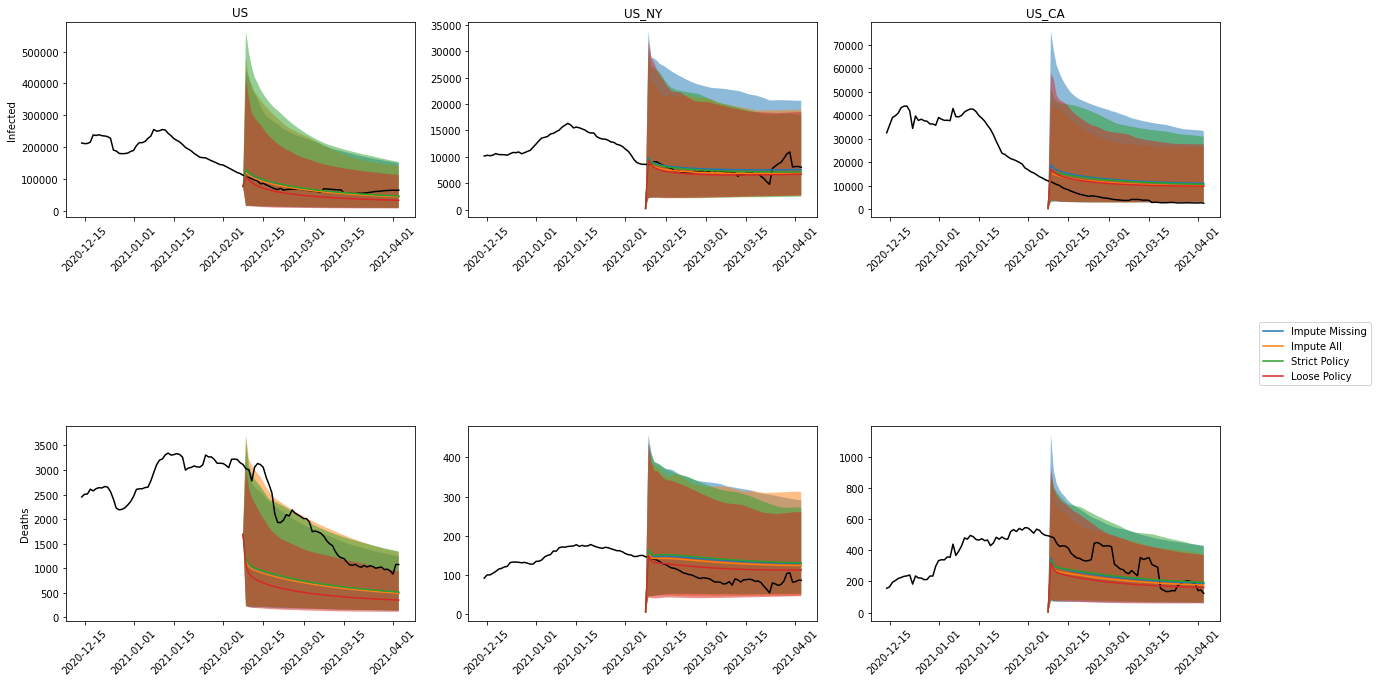

In [6]:
fig, axs = plt.subplots(nrows = 2, ncols = len(countries), figsize = (6.4*len(countries), 4.8*2))
df_subset = df[(min_date <= df.date) & (df.date <= max_date)]
for c, state in enumerate(['delI', 'delD']):
    for d, country in enumerate(countries):
        ax = axs[c][d]
        actual = df_subset.loc[(df_subset.key == country)]
        ax.plot(actual.date, actual[state + ('_smoothed' if smooth else '')], '-', color = 'k')
        ax.xaxis.set_tick_params(rotation = 45)
        if c == 0:
            ax.set_title(country)
        if d == 0:
            ax.set_ylabel({'delI': 'Infected', 'delD': 'Deaths'}[state])
        
        for e, method in enumerate(methods):
            query = f'key == "{country}" and date <= "{str(max_date.date())}" and date >= "{str(min_date.date())}"'
            all_trajectories = np.array([preds[method][i].query(query)[f'{state}_pred'] for i in range(n_trajectories)])
            mean_df = preds[method]['mean'].query(query)
            mean_trajectory = mean_df[f'{state}_pred']
            min_trajectory = np.percentile(all_trajectories, (1 - CI)/2*100, axis = 0)
            max_trajectory = np.percentile(all_trajectories, (1 - (1 - CI)/2)*100, axis = 0)
            
            ax.plot(mean_df.date, mean_trajectory, '-', color = 'C'+str(e))
            ax.fill_between(mean_df.date, min_trajectory, max_trajectory, facecolor = 'C'+str(e), alpha = 0.5)            

legend = [
        mlines.Line2D([], [],  linestyle = '-', color = 'C'+str(e), marker = None,
                     label = methods_mapping[method]) for e, method in enumerate(methods)
    ]

axs[0][-1].legend(handles = legend, loc='center left', bbox_to_anchor=(1.1, -0.7))           

plt.tight_layout()
plt.show()

## Figure 1

In [4]:
_, df, _, _, _ = load_data_features(data_dir, {
    'feature_set': 'condensed',
    'data_type': 'US',
    'include_counties': False
})

In [44]:
# indices = ['stringency_index', 'GovernmentResponseIndex', 'ContainmentHealthIndex', 'EconomicSupportIndex']
indices = ['stringency_index', 'GovernmentResponseIndex', 'ContainmentHealthIndex']
renames = {
    'stringency_index': 'Stringency Index', 
    'GovernmentResponseIndex': "Government Response Index",
    'ContainmentHealthIndex': "Containment & Health Index", 
    'EconomicSupportIndex': "Economic Support Index"
}
state = 'US_CA'
lower = '2020-06-01'
upper = '2021-02-28'

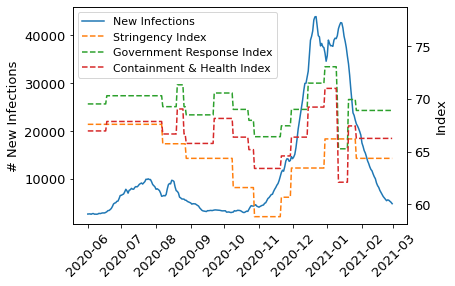

In [75]:
df_temp = df[(df.key == state) & (df.date >= lower) & (df.date <= upper)]
plt.rcParams.update({'font.size': 13})
fig = plt.figure()
plt.plot(df_temp.date, df_temp.delI_smoothed, label = 'New Infections')
# plt.plot(df_temp.date, df_temp.delD_smoothed, label = 'Deaths')
plt.ylabel("# New Infections")
ax = plt.gca()
ax.xaxis.set_tick_params(rotation = 45)
l1 = ax.get_legend_handles_labels()
plt.twinx()
for c, i in enumerate(indices):
    plt.plot(df_temp.date, df_temp[i], '--', label = renames[i], color = 'C' + str(c+1))

ax2 = plt.gca()
l2 = ax2.get_legend_handles_labels()
ax2.legend(l1[0] + l2[0], l1[1] + l2[1], loc='upper left', prop={'size': 11})
ax2.set_ylim(top = ax2.get_ylim()[1] + 5)
plt.ylabel("Index")
plt.show()
fig.savefig(f'{state}_trajectory_with_indices.pdf', dpi = 300, bbox_inches = 'tight')